In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import confusion_matrix

In [3]:
# Fetch data
data = fetch_20newsgroups()
categories = ['talk.religion.misc', 'sci.space', 'rec.motorcycles']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

# Define vocabulary
vocab = ['Religion', 'God', 'Beliefs', 'Religious', 'Believers', 'Christ', 'Church', 'Orthodox', 'Muslim', 'Bible', 'Truth', 'Morals', 'Scripture', 'Commandments', 'Christian', 'Politics', 'Culture', 'Sin', 'Interpret', 'Mormon', 'prayer'] \
        + ['star', 'sun', 'sonic', 'titan', 'jupyter', 'planets', 'astronomy', 'astronomer', 'moon', 'nasa', 'earth', 'astronomical', 'space', 'spacecraft', 'planetary', 'universe', 'supersonic', 'satellite', 'orbit'] \
        + ['speed', 'bike', 'BMW', 'BMWRA', 'helmet', 'manufacturer', 'fiberglass', 'low-speed']

vocab = [v.lower() for v in vocab]

In [4]:
### FOR TRAIN 
# Collect data for each category / train data에서 카테고리 별로 정리
data_category = {category: [] for category in categories}
for i in range(len(train.data)):
    category = train.target_names[train.target[i]]
    if category in categories:
        data_category[category].append(train.data[i])

# 단어 카운트 할 딕셔너리 초기화 
vocabcount_category = {category: {v: 0 for v in vocab} for category in categories}

# 카테고리 별로 item에 대해 데이터 정리해주고 vocab과 비교하여 카운트하기
for category, data in data_category.items():
    total_words = 0
    for dstr in data:
        words = dstr.lower().split()
        for w in words:
            if w in vocab:
                total_words += 1
                vocabcount_category[category][w] += 1
    # print(f"total {category} words in vocab = {total_words}")

    # Apply Laplace smoothing
    for k in vocabcount_category[category]:
        vocabcount_category[category][k] += 1

    # 카테고리 별 각 단어의 확률 ex : {'talk.religion.misc': {'religion': 0.041931737736735114, ...
    total = sum(vocabcount_category[category].values())
    for k in vocabcount_category[category]:
        vocabcount_category[category][k] /= total

# Compute log-probabilities
vocab_logp_category = {category: {key: np.log(value) for key, value in vocabcount.items()} 
                       for category, vocabcount in vocabcount_category.items()}

predicted_count = 0
predicted_labels = []

### FOR TEST

for i in range(len(test.data)): #1043번 반복
    # 테스트 할 데이터 불러오기
    tsample = test.data[i]
    # train 해 놓은 카테고리별 단어 로그 확률를 기준으로 정리된 test 데이터로 로그 확률을 카테고리별로 구하기 
    logp_category = {category: sum(vocab_logp_category[category].get(w, 0) 
                                   for w in tsample.lower().split() if w in vocab) 
                     for category in categories}
    # ex {'talk.religion.misc': -7.909856667269403, 'sci.space': -7.909856667269403, 'rec.motorcycles': -7.909856667269403}
    
    # 카테고리에서 가장 큰 확률의 라벨을 반환하기 > 누적
    predicted_label = max(logp_category, key=logp_category.get)
    predicted_labels.append(predicted_label)

    # 실제 라벨과 비교하여 카운트 하기
    true_label = test.target_names[test.target[i]]
    if predicted_label == true_label:
        predicted_count += 1

test_accuracy = predicted_count / len(test.data)
print("Test Accuracy(%):", test_accuracy * 100)

Test Accuracy(%): 67.40172579098753


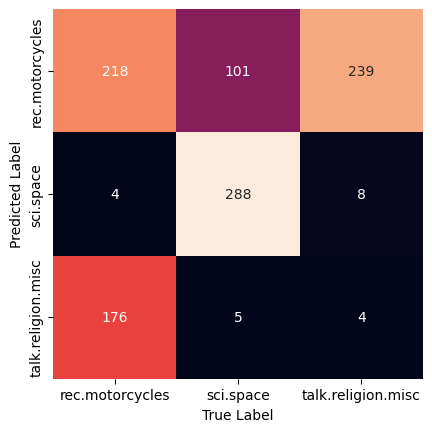

In [5]:
# Create confusion matrix
conf_matrix = confusion_matrix(test.target, [categories.index(label) for label in predicted_labels])

# Plot confusion matrix
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=test.target_names, yticklabels=test.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()